In [13]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale 
from sklearn import datasets
import pandas as pd

In [14]:
data = pd.read_csv("EducationSéries2005-2010.csv")
data = data.fillna(0)
print(data.head(20))

    Unnamed: 0 economy                series       2005       2006  2007  \
0            0     ABW  SE.SEC.CUAT.LO.FE.ZS   0.000000   0.000000   0.0   
1            1     ABW  SE.SEC.CUAT.LO.MA.ZS   0.000000   0.000000   0.0   
2            2     ABW     SE.SEC.CUAT.LO.ZS   0.000000   0.000000   0.0   
3            3     ABW  SE.SEC.CUAT.PO.FE.ZS   0.000000   0.000000   0.0   
4            4     ABW  SE.SEC.CUAT.PO.MA.ZS   0.000000   0.000000   0.0   
5            5     ABW     SE.SEC.CUAT.PO.ZS   0.000000   0.000000   0.0   
6            6     ABW  SE.SEC.CUAT.UP.FE.ZS   0.000000   0.000000   0.0   
7            7     ABW  SE.SEC.CUAT.UP.MA.ZS   0.000000   0.000000   0.0   
8            8     ABW     SE.SEC.CUAT.UP.ZS   0.000000   0.000000   0.0   
9            9     ALB  SE.SEC.CUAT.LO.FE.ZS   0.000000   0.000000   0.0   
10          10     ALB  SE.SEC.CUAT.LO.MA.ZS   0.000000   0.000000   0.0   
11          11     ALB     SE.SEC.CUAT.LO.ZS   0.000000   0.000000   0.0   
12          

In [15]:
# Kohonen Neural Network
class Kohonen:
    def __init__(self, model=None, net_dim=(13,13), learning_rate=0.01,iterations=100, n_classes=3):
        self.model=model
        self.net_dim=net_dim
        self.iterations=iterations
        self.learning_rate=learning_rate
        self.radius=np.average(np.array(net_dim))/2
        self.n_classes=n_classes
        # Pour tenir compte du voisinage
        zx = np.arange(0,self.net_dim[0],1)
        zy=np.arange(0,self.net_dim[1],1)
        zx, zy=np.meshgrid(zx,zy, indexing='ij')
        self.mesh_init=np.array([zx, zy])

    def getCentroids(self):
        return self.model

    # neurone gagnant
    def fittest_neuron(self, feature):
        # calcul des distances
        distance = np.sqrt(np.sum((self.model-feature)**2, axis=2))
        pos=np.unravel_index(np.argmin(distance, axis=None), distance.shape)
        # Indice unique -> (?,?,?)
        return(self.model[pos], pos)

    def h(self, distance, radius):
        return np.exp(-distance/(2*(radius**2)))
        
        # Apprentissage
    def train(self, x_train):
        #Initisalisation
        if self.model is None:
            self.model = np.zeros((self.net_dim[0],self.net_dim[1], x_train.shape[1]))
            Xmn=np.average(x_train,axis=0)# Barycentre
            Xstd=np.std(x_train,axis=0)# L'écart type pour chaque axe
            k=0
            for i in range(0,self.net_dim[0]):
                for j in range(0,self.net_dim[1]):
                    self.model[i,j]=Xmn+Xstd*(2*np.random.rand()-1)/2
                    #␣,→Points autour du barycentre
                    k+=1

        print("Début d'entrainement : carte(",self.model.shape[0],'x',self.model.shape[1],")")
        for i in range(self.iterations):
            if (i+1)%(self.iterations/5)==0:
                print(i+1,'sur',self.iterations,'iterations.')
            for feature in x_train:#pour chaque exemple
                # Neurone gagnant
                fittest,fittest_idx = self.fittest_neuron(feature)
                # paramètre adaptatifs
                r = self.radius**(1-i/self.iterations)# début:radius ... fin:1
                l = self.learning_rate**(i/self.iterations)# début:1 ... fin:0.1
                
                # Tenir compte du voisinage
                mesh = np.array(self.mesh_init)
                mesh[0] = mesh[0]-fittest_idx[0]
                mesh[1] = mesh[1]-fittest_idx[1]
                mesh=np.sqrt(np.sum(mesh**2, axis=0))
                neighbor_mask=mesh<=r
                
                # Mise à jour
                mesh[neighbor_mask] = self.h(mesh[neighbor_mask], r)
                self.model[neighbor_mask] = self.model[neighbor_mask]+l*np.multiply(mesh[neighbor_mask][:, np.newaxis], (feature-self.model)[neighbor_mask])

    def label_map(self, x_train, y_train): # Classe avec le vote maximum (lors␣,→du test)
        self.labels = np.zeros((self.model.shape[0],self.model.shape[1],self.n_classes))
        for idx, feature in enumerate(x_train):
            distance = np.sqrt(np.sum((self.model-feature)**2, axis=2))
            pos=np.unravel_index(np.argmin(distance, axis=None), distance.shape)
            self.labels[pos[0], pos[1], y_train[idx]]+=1

        self.labels = np.argmax(self.labels, axis=2)
        return self.labels    

    def accuracy(self, x_test, y_test):
        t=0
        for idx, feature in enumerate(x_test):
            distance = np.sqrt(np.sum((self.model-feature)**2, axis=2))
            pos=np.unravel_index(np.argmin(distance, axis=None), distance.shape)
            if self.labels[pos[0], pos[1]] == y_test[idx]:
                t+=1
        
        return t / len(y_test)
    def show_map(self):
        for i in range(0,self.labels.shape[0]):
            for j in range(0,self.labels.shape[1]):
                plt.text(i,  j,str(self.labels[i,j]), color=plt.cm.rainbow(self.labels[i,j]/10.))
        plt.axis([0,self.model.shape[0],0,self.model.shape[1]])
        plt.show()

    def predict(self,x):
        distance = np.sqrt(np.sum((self.model-feature)**2, axis=2))
        pos=np.unravel_index(np.argmin(distance, axis=None), distance.shape)
        return self.labels[pos[0],pos[1]]

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
Ss = StandardScaler()
lb = LabelBinarizer()
le = LabelEncoder()

X = data.iloc[:,3:].values
print("X BEFORE :",X)
X = StandardScaler().fit_transform(X).astype(np.uint8)
print("X AFTER :", X)


train = StandardScaler().fit_transform(data.values)

Y = data.iloc[:,1].values

Y1 = lb.fit_transform(Y).astype(np.uint8)
Y2 = le.fit_transform(Y).astype(np.uint8)

X BEFORE : [[ 0.          0.          0.          0.          0.         58.69797897]
 [ 0.          0.          0.          0.          0.         63.29758835]
 [ 0.          0.          0.          0.          0.         60.79969025]
 ...
 [48.79795837 49.17341995 50.01156998 51.64524841 55.27593994 56.05413818]
 [53.4396019  54.57670975 54.17068863 57.08401108 59.16276169 60.22819901]
 [50.95872879 51.69332123 51.94974899 54.18270874 57.0944519  58.01028061]]
X AFTER : [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [1 1 0 0 0 0]
 [1 1 1 1 1 0]
 [1 1 1 0 0 0]]


In [17]:
print(X)

print(Y1)
print(Y2)

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [1 1 0 0 0 0]
 [1 1 1 1 1 0]
 [1 1 1 0 0 0]]
[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
[  0   0   0   0   0   0   0   0   0   1   1   1   1   1   1   1   1   1
   2   2   2   2   2   2   3   3   3   3   3   3   3   3   3   4   4   4
   4   4   4   5   5   5   5   5   5   5   5   5   6   6   6   6   6   6
   7   7   7   7   7   7   7   7   7   8   8   8   8   8   8   8   8   8
   9   9   9   9   9   9   9   9   9  10  10  10  10  10  10  11  11  11
  11  11  11  11  11  11  12  12  12  12  12  12  12  12  12  13  13  13
  13  13  13  13  13  13  14  14  14  14  14  14  14  14  14  15  15  15
  15  15  15  15  15  15  16  16  16  16  16  16  17  17  17  17  17  17
  17  17  17  18  18  18  18  18  18  18  18  18  19  19  19  19  19  19
  20  20  20  20  20  20  20  20  20  21  21  21  21  21  21  21  21  21
  22  22  22  22  22  22  23  23  23  23  23  23  23  

In [18]:
print(X)

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [1 1 0 0 0 0]
 [1 1 1 1 1 0]
 [1 1 1 0 0 0]]


In [19]:
# Création et entrainement  : carte 15x15
som=Kohonen(net_dim=(15,15), iterations=400)
som.train(X)

Début d'entrainement : carte( 15 x 15 )
80 sur 400 iterations.
160 sur 400 iterations.
240 sur 400 iterations.
320 sur 400 iterations.
400 sur 400 iterations.


[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
[  0   0   0   0   0   0   0   0   0   1   1   1   1   1   1   1   1   1
   2   2   2   2   2   2   3   3   3   3   3   3   3   3   3   4   4   4
   4   4   4   5   5   5   5   5   5   5   5   5   6   6   6   6   6   6
   7   7   7   7   7   7   7   7   7   8   8   8   8   8   8   8   8   8
   9   9   9   9   9   9   9   9   9  10  10  10  10  10  10  11  11  11
  11  11  11  11  11  11  12  12  12  12  12  12  12  12  12  13  13  13
  13  13  13  13  13  13  14  14  14  14  14  14  14  14  14  15  15  15
  15  15  15  15  15  15  16  16  16  16  16  16  17  17  17  17  17  17
  17  17  17  18  18  18  18  18  18  18  18  18  19  19  19  19  19  19
  20  20  20  20  20  20  20  20  20  21  21  21  21  21  21  21  21  21
  22  22  22  22  22  22  23  23  23  23  23  23  23  23  23  24  24  24
  24  24  24  24  24  24  25  25  25  25  25  25  25  25  25  26  26  26
  26

In [20]:
som.label_map(X, Y2)
som.show_map()

counts, bins=np.histogram(som.labels.flatten())
plt.figure(figsize=(5,2))
plt.hist(bins[:-1], weights=counts)

IndexError: index 3 is out of bounds for axis 2 with size 3

In [19]:
from minisom import MiniSom

som = MiniSom(6, 6, 6, sigma=0.3, learning_rate=0.5)
#Then we train the SOM on 100 iterations.
som.train_random(X, 100)

In [20]:

cleandataset=pd.DataFrame(standard.fit_transform(X))
cleandataset.head()
cleandataset.tail()

NameError: name 'standard' is not defined

In [25]:
from matplotlib.gridspec import GridSpec
som=MiniSom(13,13,6,sigma=0.5,neighborhood_function="gaussian") #4 for the independent varibles data
som.train_random(X,400) #30000 refers to the no of iteration for the model.

In [26]:
target = le.inverse_transform(Y)
label_map=som.labels_map(X,target)
label_names=np.unique(target)

print(target)

ValueError: y contains previously unseen labels: ['ABW' 'ALB' 'AND' 'ARE' 'ARG' 'AUS' 'AUT' 'AZE' 'BEL' 'BFA' 'BGR' 'BHR'
 'BHS' 'BIH' 'BLR' 'BLZ' 'BMU' 'BOL' 'BRA' 'CAN' 'CHE' 'CHL' 'CHN' 'CMR'
 'COL' 'CRI' 'CYM' 'CYP' 'CZE' 'DEU' 'DNK' 'DOM' 'DZA' 'ECU' 'EGY' 'ESP'
 'EST' 'ETH' 'FIN' 'FJI' 'FRA' 'GBR' 'GHA' 'GIN' 'GRC' 'GTM' 'HKG' 'HND'
 'HUN' 'IDN' 'IRL' 'IRN' 'ISL' 'ISR' 'ITA' 'JOR' 'JPN' 'KAZ' 'KEN' 'KGZ'
 'KHM' 'KOR' 'KWT' 'LBN' 'LCA' 'LKA' 'LSO' 'LTU' 'LUX' 'LVA' 'MAC' 'MDA'
 'MDV' 'MEX' 'MLI' 'MLT' 'MNG' 'MYS' 'NGA' 'NLD' 'NOR' 'NZL' 'OMN' 'PAK'
 'PAN' 'PER' 'PHL' 'POL' 'PRI' 'PRT' 'PRY' 'PSE' 'PYF' 'QAT' 'ROU' 'RUS'
 'SEN' 'SGP' 'SLV' 'SRB' 'SSD' 'SVN' 'SWE' 'SYR' 'TCD' 'TGO' 'THA' 'TON'
 'TTO' 'TUN' 'TUR' 'UGA' 'URY' 'USA' 'VEN' 'VNM' 'ZAF']

In [13]:
print(len(label_names))


117


(3, 7)
(2, 6)
(3, 6)
(0, 8)
(0, 9)
(11, 2)
(10, 2)
(12, 2)
(0, 7)
(1, 5)
(2, 9)
(1, 7)
(1, 6)
(2, 8)
(11, 3)
(11, 1)
(3, 9)
(10, 1)
(2, 5)
(0, 6)
(2, 7)
(1, 8)
(1, 10)
(11, 10)
(1, 9)
(3, 8)
(4, 7)
(7, 8)
(7, 9)
(0, 5)
(4, 0)


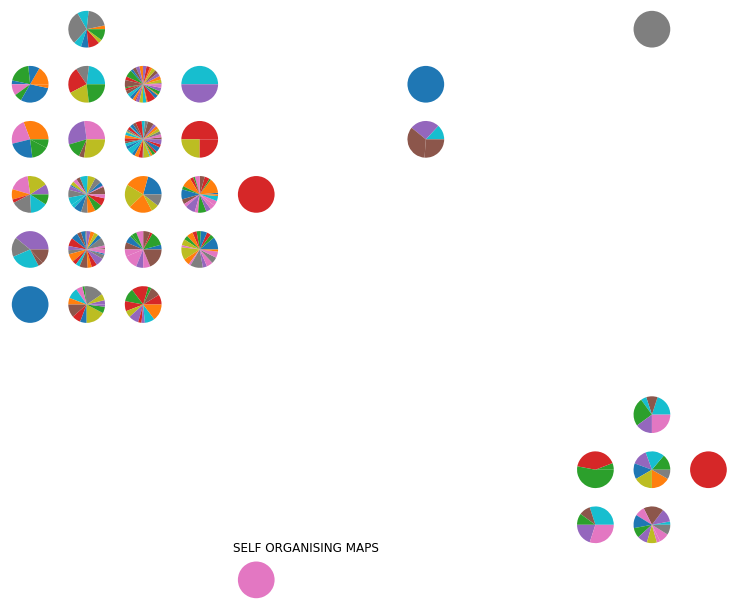

In [14]:
plt.figure(figsize=(13,13))
the_grid=GridSpec(13,13)
for position in label_map.keys():
    print(the_grid.)
    label_fracs=[label_map[position][l] for l in label_names]
    plt.subplot(the_grid [12-position[1],position[0]],aspect=1)
    patches,texts=plt.pie( label_fracs )

#plt.legend(label_names,,ncol=10)
plt.title("SELF ORGANISING MAPS",loc ="left")
plt.show()

C:\Users\ayman\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


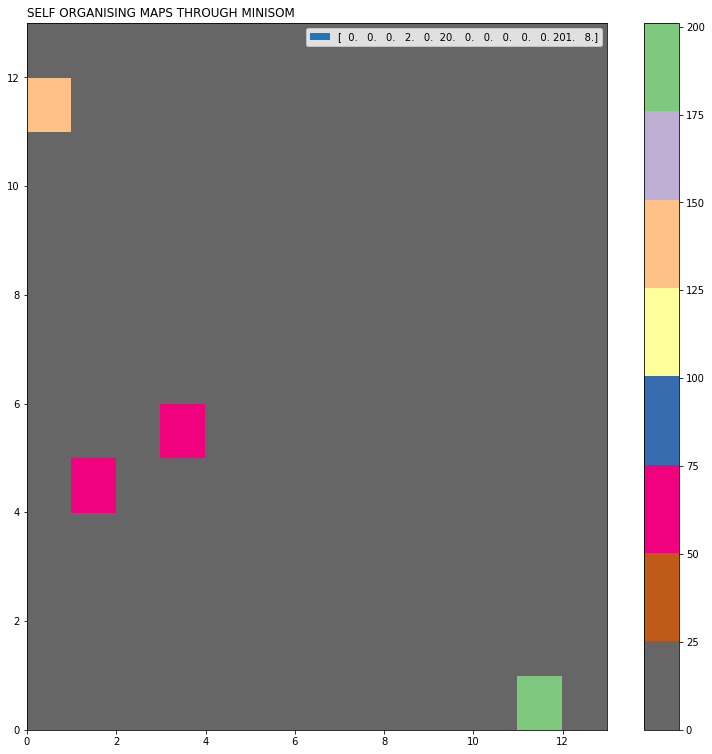

In [15]:
plt.figure(figsize=(13,13))
frequencies=np.zeros((13,13))
for position,values in som.win_map(cleandataset.to_numpy()).items():
    frequencies[position[0],position[1]]=len(values)
plt.pcolor(frequencies,cmap="Accent_r")
plt.title("SELF ORGANISING MAPS THROUGH MINISOM",loc ="left")
plt.legend(frequencies,ncol=15)
plt.colorbar()
plt.show()

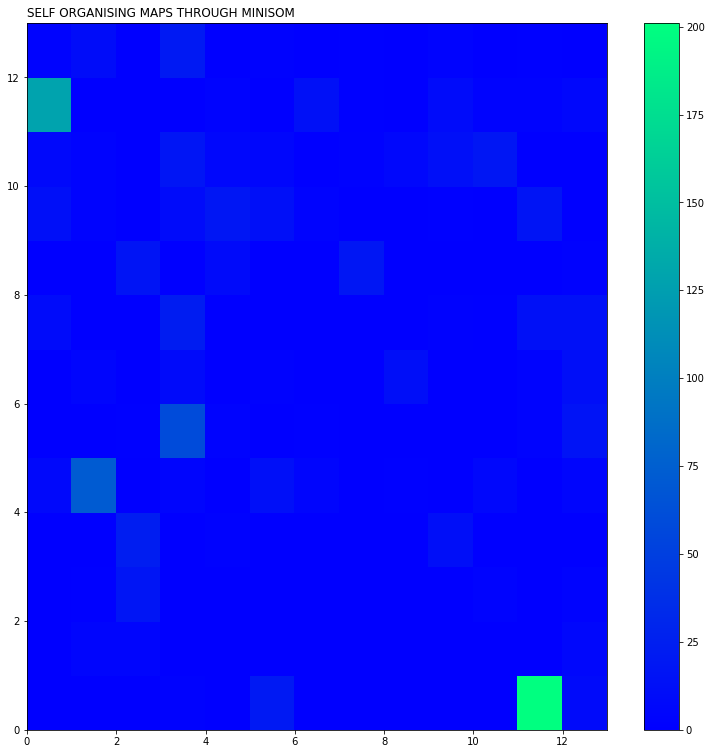

In [16]:
plt.figure(figsize=(13,13))
frequencies=np.zeros((13,13))
for position,values in som.win_map(cleandataset.to_numpy()).items():
    frequencies[position[0],position[1]]=len(values)
plt.pcolor(frequencies,cmap="winter")
plt.title("SELF ORGANISING MAPS THROUGH MINISOM",loc ="left")
plt.colorbar()
plt.show()

No handles with labels found to put in legend.


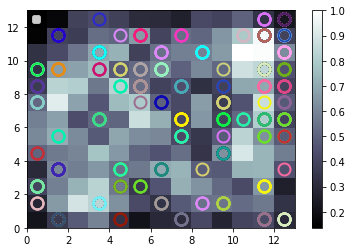

In [18]:
from numpy import genfromtxt,array,linalg,zeros,apply_along_axis

data = X
# normalization to unity of each pattern in the data
data = apply_along_axis(lambda x: x/linalg.norm(x),1,data)

from minisom import MiniSom
### Initialization and training ###
som = MiniSom(13,13,X.shape[1],sigma=1.0,learning_rate=0.5)
som.random_weights_init(data)

som.train_random(data,100) # training with 100 iterations

from pylab import plot,axis,show,pcolor,colorbar,bone,legend
bone()
pcolor(som.distance_map().T) # distance map as background
colorbar()

# use different colors and markers for each label
markers = 'o'

from random import randint

color = []
n = 117
for i in range(n):
    color.append('#%06X' % randint(0, 0xFFFFFF))

for cnt,xx in enumerate(data):
    w = som.winner(xx) # getting the winner
    # palce a marker on the winning position for the sample xx
    plot(w[0]+.5,w[1]+.5,markers,markerfacecolor='None',markeredgecolor=color[Y[cnt]],markersize=12,markeredgewidth=2)

legend()
show() # show the figure